In [1]:
#Import Turing, Distributions, StatsBase, DataFrames and CSV
using Turing, Distributions, StatsBase, DataFrames, CSV

# Import MCMCChain, Plots and StatsPlots
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/RZOZ8/src/Turing.jl:24


false

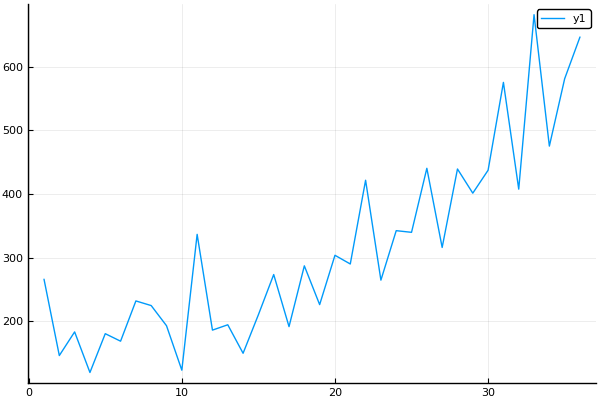

In [2]:
# Load in the shampoo dataset (can be downloaded from https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv)
df = CSV.read("shampoo.csv")
s = Float64[]
for ele in df[:Sales]
    push!(s, ele)
end
pyplot()
plot(s)

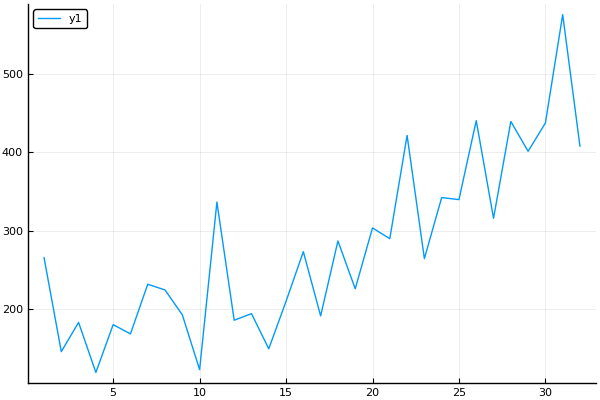

In [3]:
# Split into training and test sets. We will predict for the next 4 days using the data from the past 32 days
train_percentage = 0.9
s_train = s[1:floor(Int, train_percentage*length(s))]
N = length(s_train)

# Plot the training data
plot(s_train)

In [5]:
#Defining the model
σ = 1
@model MA(x, N) = begin
    beta_1 ~ Uniform(0, 1)
    beta_2 ~ Uniform(0, 1)
    for t in 3:N
        μ = rand(Normal(0,σ)) + beta_1 * rand(Normal(0, 1)) + beta_2 * rand(Normal(0, 1)) 
        x[t] ~ Normal(μ, 0.1) 
    end
end;

In [6]:
# This is temporary while the reverse differentiation backend is being improved.
Turing.setadbackend(:forward_diff)

# Sample using NUTS(n_iters::Int, n_adapts::Int, δ::Float64), where:
# n_iters::Int : The number of samples to pull.
# n_adapts::Int : The number of samples to use with adapatation.
# δ::Float64 : Target acceptance rate.

chain = sample(MA(s_train, N), NUTS(500, 200, 0.65) )

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/support/hmc_core.jl:247
┌ Info: [Turing] found initial ϵ: 0.037458607340569855
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/support/hmc_core.jl:239
┌ Info:  Adapted ϵ = 5.575636821350982e-84, std = [1.0, 1.0]; 200 iterations is used for adaption.
└ @ Turing.Inference /home/saumya/.julia/packages/Turing/RZOZ8/src/inference/adapt/adapt.jl:90


[NUTS] Finished with
  Running time        = 3.4458952430000025;
  #lf / sample        = 0.0;
  #evals / sample     = 0.002;
  pre-cond. metric    = [1.0, 1.0].


Object of type Chains, with data of type 500×8×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = beta_1, beta_2

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean     │ std        │ naive_se    │ mcse        │
│     │ Symbol     │ Float64  │ Float64    │ Float64     │ Float64     │
├─────┼────────────┼──────────┼────────────┼─────────────┼─────────────┤
│ 1   │ beta_1     │ 0.241594 │ 0.0332232  │ 0.00148579  │ 0.00258014  │
│ 2   │ beta_2     │ 0.998172 │ 0.00506366 │ 0.000226454 │ 0.000393015 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1  

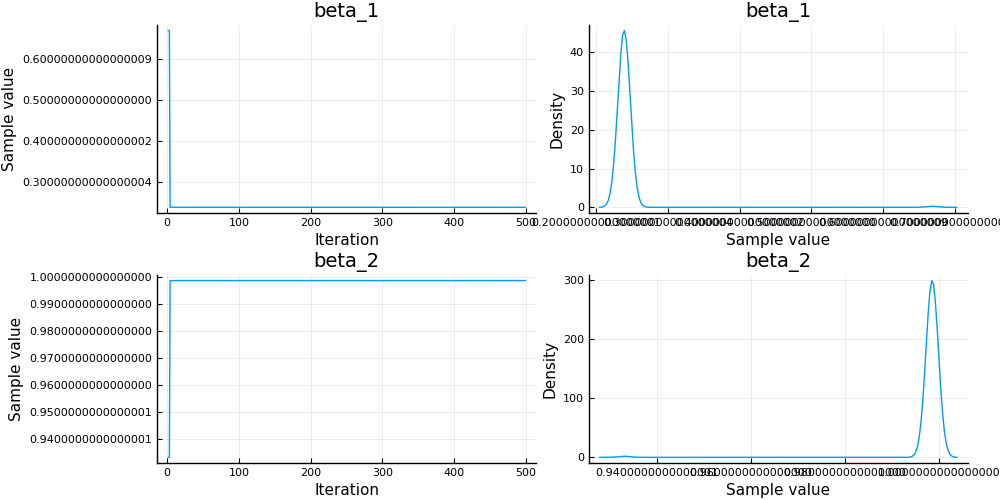

In [7]:
#Plotting the chain distribution of the sampled parameters and their values over the 500 iterations.
#Note that roughly the first 50 samples are the warmup samples that we will remove later on
plot(chain)

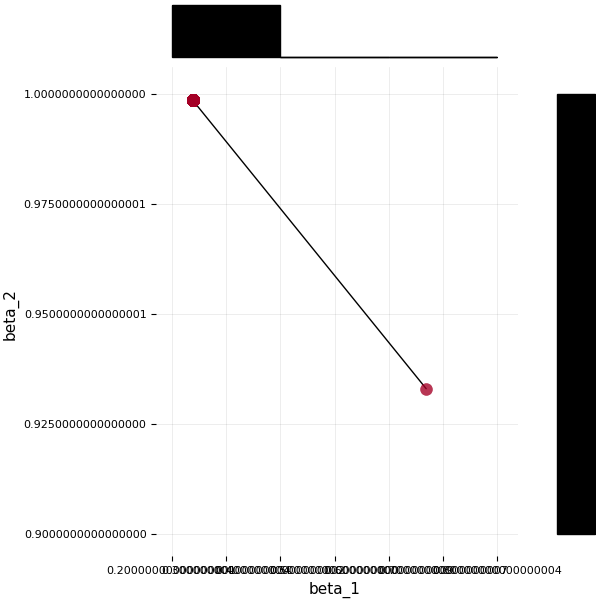

In [8]:
#Plotting the corner plot for the chain
corner(chain)

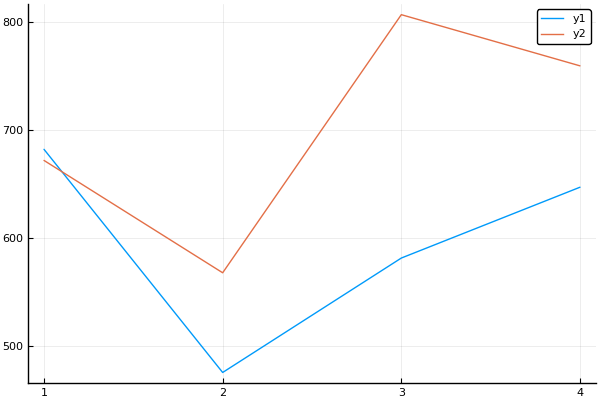

In [9]:
#Removing the warmup samples
chains_new = chain[50:500]

# Getting the mean values of the sampled parameters
beta_1 = mean(chains_new[:beta_1].value)
beta_2 = mean(chains_new[:beta_2].value)

#Obtaining the test data
s_test = s[N + 1:length(s)]

#Obtaining the predicted results using the AR(2) definition
s_pred = Float64[]
first_ele =  s_train[N]*beta_1 + s_train[N - 1]*beta_2 + rand(Normal(0,1))
push!(s_pred, first_ele)
second_ele = s_pred[1]*beta_1 + s_train[N]*beta_2 + rand(Normal(0,1))
push!(s_pred, second_ele)
for i=3:length(s_test)
    next_ele = s_pred[i - 1]*beta_1 + s_pred[i - 2]*beta_2 + rand(Normal(0,1))
    push!(s_pred, next_ele)
end

#Plotting the test and the predicted data for comparison
plot(s_test)
plot!(s_pred)